# Quantum machine learning in Amazon Braket Hybrid Jobs

This notebook demonstrates  training a parameterized quantum circuit Born machine (QCBM) for an unsupervised generative modelling task.


## Quantum Circuit Born Machine 

Quantum circuits are a natural fit for generative modelling because they are inherently probabilistic; the wavefunction encodes a probability according to the Born rule:

$$p(x)=|\langle x|\psi\rangle|^2$$

In quantum mechanics, we do not have access to $p(x)$ directly, but we can efficiently sample using projective measurements [1]. This is an implicit generative model similar to generative adversarial networks (GANs). Quantum circuits allow fast sampling from a high-dimension distribution, and have large expressive power. 


## References


[1] Benedetti, Marcello, Delfina Garcia-Pintos, Oscar Perdomo, Vicente Leyton-Ortega, Yunseong Nam, and Alejandro Perdomo-Ortiz. “A Generative Modeling Approach for Benchmarking and Training Shallow Quantum Circuits.” Npj Quantum Information 5, no. 1 (May 27, 2019): 1–9. https://doi.org/10.1038/s41534-019-0157-8.

[2] Liu, Jin-Guo, and Lei Wang. “Differentiable Learning of Quantum Circuit Born Machine.” Physical Review A 98, no. 6 (December 19, 2018): 062324. https://doi.org/10.1103/PhysRevA.98.062324.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from braket.devices import LocalSimulator

from braket.experimental.algorithms.quantum_circuit_born_machine.qcbm import QCBM, mmd_loss

%matplotlib inline


n_qubits = 3
n_layers = 1

init_params = np.random.rand(3 * n_layers * n_qubits)

device = LocalSimulator()

qcbm = QCBM(device, n_qubits, n_layers, np.random.rand(1))
init_params = np.random.rand(3 * n_layers * n_qubits)

print(qcbm.create_circuit(init_params))

T  : |   0    |   1    |   2    |3|4|5|Result Types|
                                                    
q0 : -Rx(0.87)-Rz(0.76)-Rx(0.48)-C---X-Probability--
                                 |   | |            
q1 : -Rx(0.16)-Rz(0.84)-Rx(0.09)-X-C-|-Probability--
                                   | | |            
q2 : -Rx(0.09)-Rz(0.89)-Rx(0.26)---X-C-Probability--

T  : |   0    |   1    |   2    |3|4|5|Result Types|


## Training data

As an example, we consider the toy example of learning a mixture of Gaussian distributions. We set a numpy random seed to produce the same data each time, but try experimenting with the number of peaks and number of qubits to produce harder or easier data sets. For this example, the target distribution $p(x)$ is a Gaussian on 5 bits (so $2^5$ possible values), with peaks at $\mu_1=7$ and $\mu_2=20$, with standard deviations $\sigma_1=1$, $\sigma_2 = 2$. We generate and plot the data as a probability density function in the cell below.

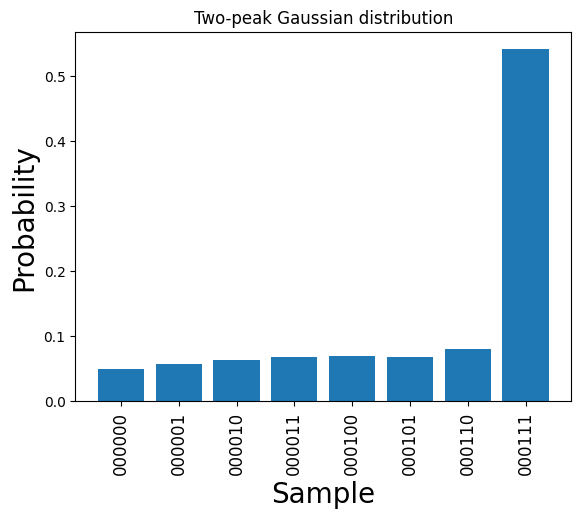

In [12]:
def gaussian(n_qubits, mu, sigma=1):
    x = np.arange(2**n_qubits)
    gaussian = 1.0 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-((x - mu) ** 2) / (2 * sigma**2))
    return gaussian / sum(gaussian)


data = gaussian(n_qubits, mu=4, sigma=5) + gaussian(n_qubits, mu=20, sigma=2)
data = data / sum(data)
labels = ["{0:{fill}6b}".format(i, fill="0") for i in range(len(data))]

plt.bar(range(2**n_qubits), data)
plt.xticks(list(range(len(data))), labels, rotation="vertical", size=12)
plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)
plt.title("Two-peak Gaussian distribution")
plt.show()

## Hyperparameters 

Next, we set the hyperparameters for our training job. To keep it simple, we only consider the following hyperparameters: number of qubits `n_qubits`, number of layers in the QCBM `n_layers`, and the number of iterations in the optimization algorithm.

The number of layers determines how many parameters are in the quantum circuit. For the QCBM, we need `n_params = 3 * n_layers * n_qubits`.

Note that the hyperparameters are defined in a Python dictionary of strings. Within the `qcbm_job.py` script, we will need to convert from strings back into integers.


In [3]:
# Declare hyperparameters for QCBM
n_iterations = 5
n_layers = 3

init_params = np.random.rand(3 * n_layers * n_qubits)

qcbm = QCBM(device, n_qubits, n_layers, data)

In [4]:
# Traing circuit
from scipy.optimize import minimize

history = []


def callback(x):
    loss = mmd_loss(qcbm.probabilities(x), data)
    history.append(loss)


result = minimize(
    lambda x: mmd_loss(qcbm.probabilities(x), data),
    x0=init_params,
    method="L-BFGS-B",
    jac=lambda x: qcbm.gradient(x),
    options={"maxiter": n_iterations},
    callback=callback,
)

print(result)

      fun: 0.020391614858213725
 hess_inv: <27x27 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03291537, -0.00320142,  0.02072104,  0.02561834,  0.01503483,
        0.01933868, -0.0189369 ,  0.00191043, -0.0177195 , -0.05956417,
        0.01457903, -0.05793134, -0.00303974,  0.00421029, -0.00782512,
       -0.0035192 ,  0.02166619,  0.00080432, -0.01757222, -0.01998697,
       -0.02265347,  0.01081995,  0.00016083,  0.01352678,  0.01894378,
       -0.02176516,  0.01599399])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 8
      nit: 5
     njev: 8
   status: 1
  success: False
        x: array([ 0.11517855,  1.30879174, -0.47211702,  0.87746681,  0.34632767,
        0.90537291,  0.66659198,  0.43230802,  0.6067056 , -0.08672674,
        0.07719887,  0.47400083,  1.02721278,  0.25096282,  1.12034986,
        0.50348543, -0.15283659,  0.8808113 ,  0.86163584,  0.07196046,
        0.37619079, -0.19883943,  0.30581899, -0.15317798, -0.07549056,
        

Awesome! Our first quantum machine learning job finished! Now let’s look at the convergence of the loss function.

Text(0.5, 1.0, 'Convergence of the loss function')

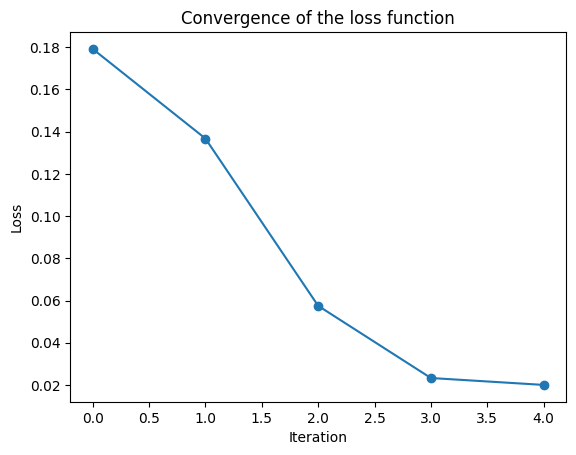

In [10]:
plt.plot(history, "-o")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence of the loss function")

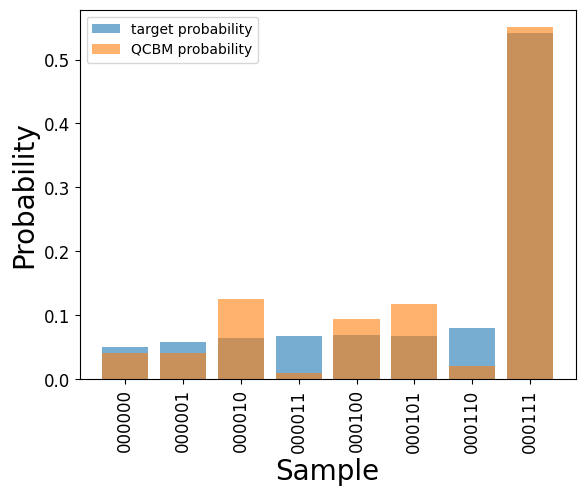

In [14]:
# Plotting the original probability distribution, and the QCBM prediction probability

qcbm_probs = qcbm.probabilities(result["x"])

labels = ["{0:{fill}6b}".format(i, fill="0") for i in range(len(data))]

plt.bar(range(2**n_qubits), data, label="target probability", alpha=0.6)
plt.bar(range(2**n_qubits), qcbm_probs, label="QCBM probability", alpha=0.6)
plt.xticks(list(range(len(data))), labels, rotation="vertical", size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

plt.legend()
plt.show()

Great! As expected, the QCBM probability distribution closes matches the target distribution. 